In [ ]:

#read ../data/train_clusters-4-v0.csv

import pandas as pd
from pathlib import Path

from sklearn.linear_model import LogisticRegression
data_dir = Path('../data')
train_data = {}
test_data = {}
fname='clusters-4-v0.csv'

df = pd.read_csv(data_dir / f'train_{fname}')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# assume df is already loaded (from train_{fname} earlier). If not, uncomment next line to load original file:
# df = pd.read_csv(data_dir / fname)

# create features and label
X = df.drop(columns=['y']).values
y = df['y'].values


# create train/test split (from this dataframe)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# fit logistic regression pipeline
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=1))
model.fit(X_train, y_train)

# predict and report
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))


Test accuracy: 0.8713
              precision    recall  f1-score   support

           1     0.9130    0.8289    0.8690        76
           2     0.7711    0.8767    0.8205        73
           3     0.8493    0.8052    0.8267        77
           4     0.9615    0.9740    0.9677        77

    accuracy                         0.8713       303
   macro avg     0.8737    0.8712    0.8710       303
weighted avg     0.8750    0.8713    0.8716       303



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score

models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()),
                                    ('clf', LogisticRegression(max_iter=2000, random_state=1))]),

    'LogisticRegression+Poly(deg2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, random_state=1))
    ]),

    'SVC_linear': Pipeline([('scaler', StandardScaler()),
                            ('clf', SVC(kernel='linear', C=1.0, random_state=1))]),

    'SVC_rbf': Pipeline([('scaler', StandardScaler()),
                         ('clf', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=1))]),

    'RF1': RandomForestClassifier(n_estimators=200, min_samples_leaf=1, max_depth=2, random_state=1, n_jobs=-1),
    'RF2': RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=5, random_state=1, n_jobs=-1),

    'MLP(5,)': Pipeline([('scaler', StandardScaler()),
                        ('clf', MLPClassifier(hidden_layer_sizes=(5,), max_iter=2000, random_state=1))]),
    'MLP(5,5)': Pipeline([('scaler', StandardScaler()),
                          ('clf', MLPClassifier(hidden_layer_sizes=(5,5), max_iter=2000, random_state=1))]),
    'MLP(5,5,5)': Pipeline([('scaler', StandardScaler()),
                            ('clf', MLPClassifier(hidden_layer_sizes=(5,5,5), max_iter=2000, random_state=1))]),
    'MLP(10,)': Pipeline([('scaler', StandardScaler()),
                         ('clf', MLPClassifier(hidden_layer_sizes=(10,), max_iter=2000, random_state=1))]),
}

import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.base import clone

results = []
for name, est in models.items():
    mdl = clone(est)
    mdl.fit(X_train, y_train)
    for ds, X, y in [('train', X_train, y_train), ('test', X_test, y_test)]:
        y_pred = mdl.predict(X)
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, average='macro', zero_division=0)
        rec = recall_score(y, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y, y_pred, average='macro', zero_division=0)
        results.append({
            'model': name,
            'dataset': ds,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
        #print(f"{name:25s},{ds:5s},{acc:.4f},{prec:.4f},{rec:.4f},{f1:.4f}")

df_results = pd.DataFrame(results)
df_results.to_csv('model_train_test_metrics.csv', index=False)
print("Saved to model_train_test_metrics.csv")



Saved to model_train_test_metrics.csv


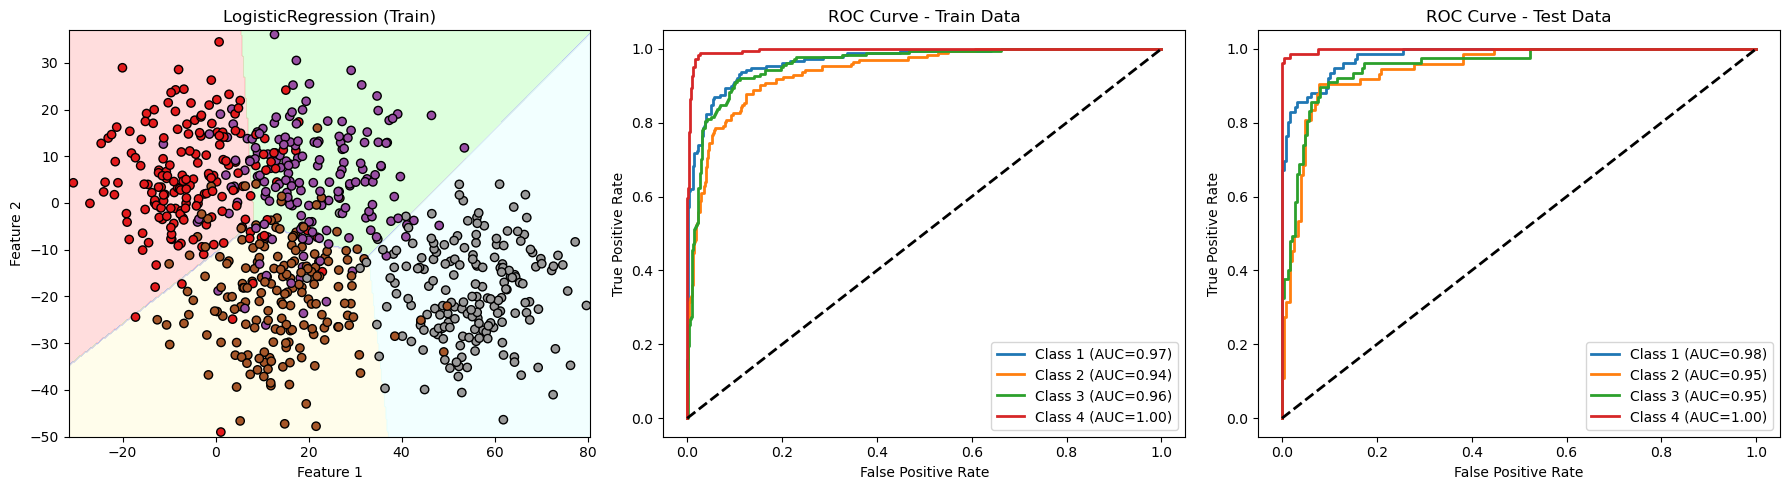

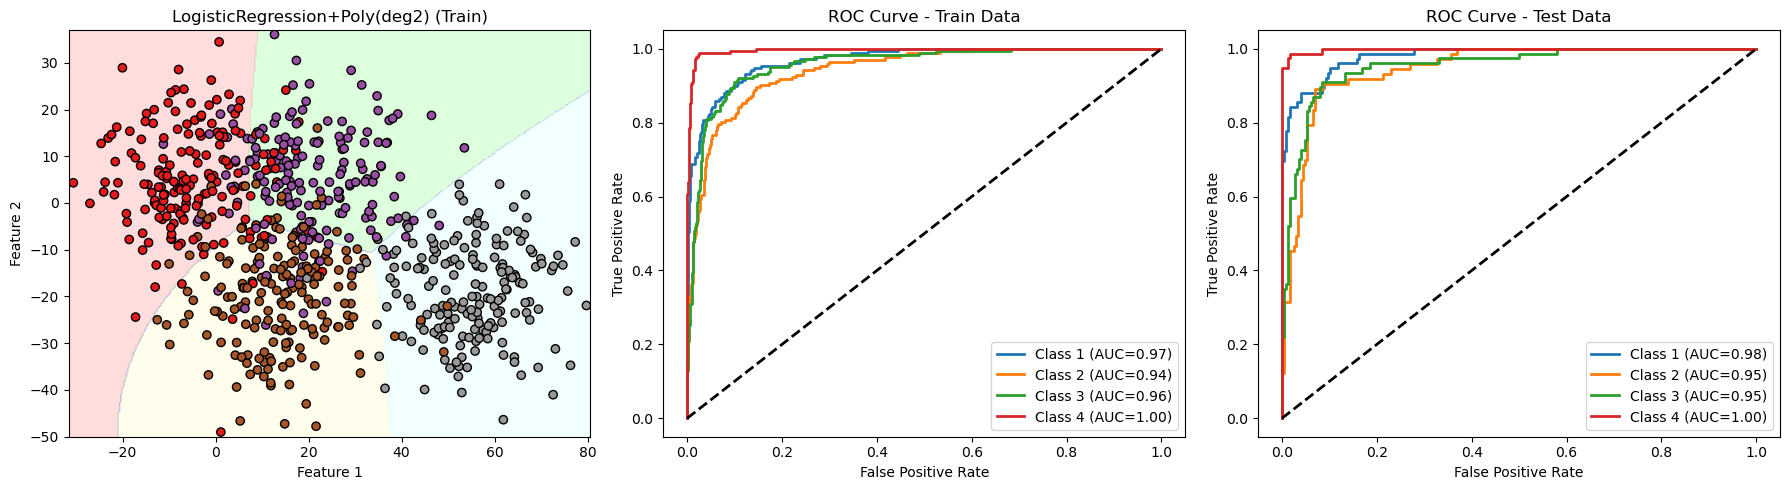

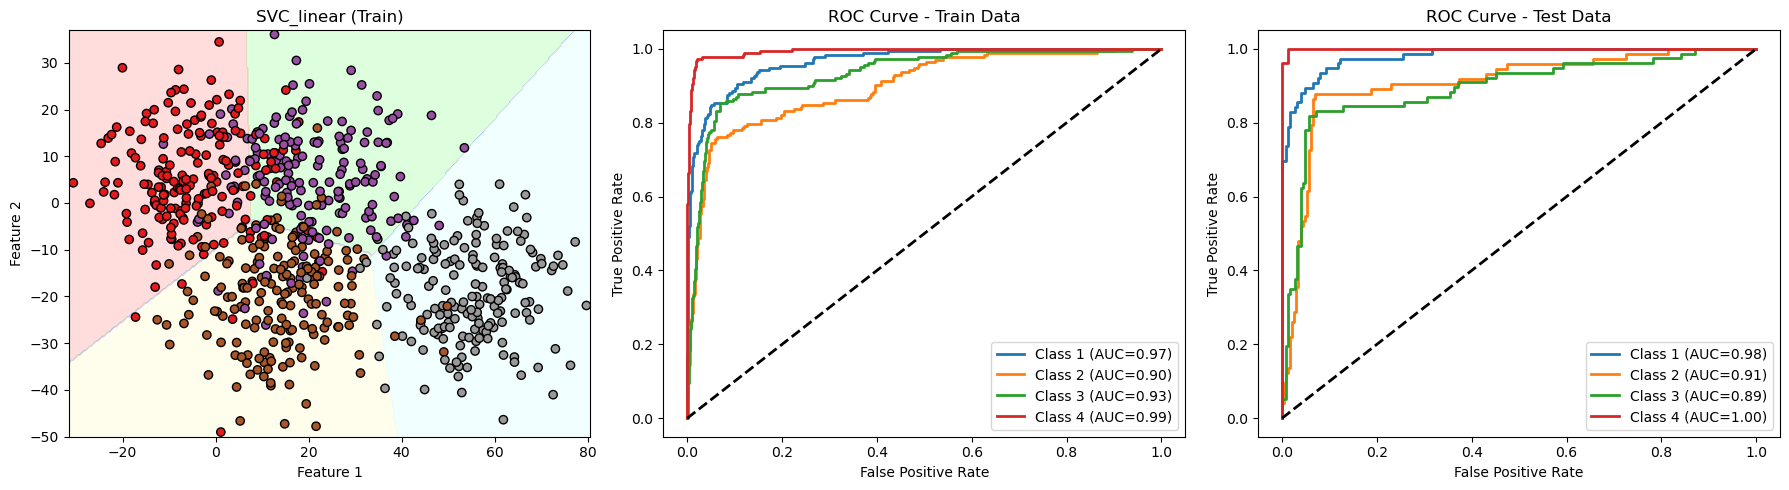

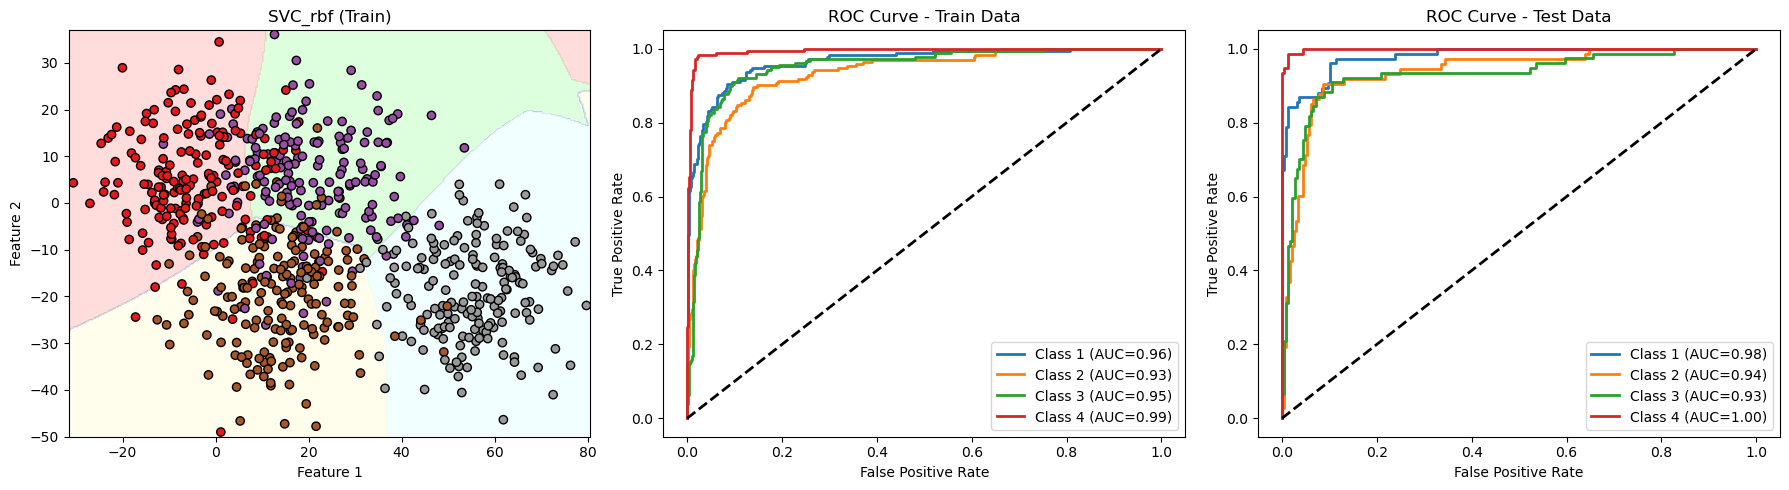

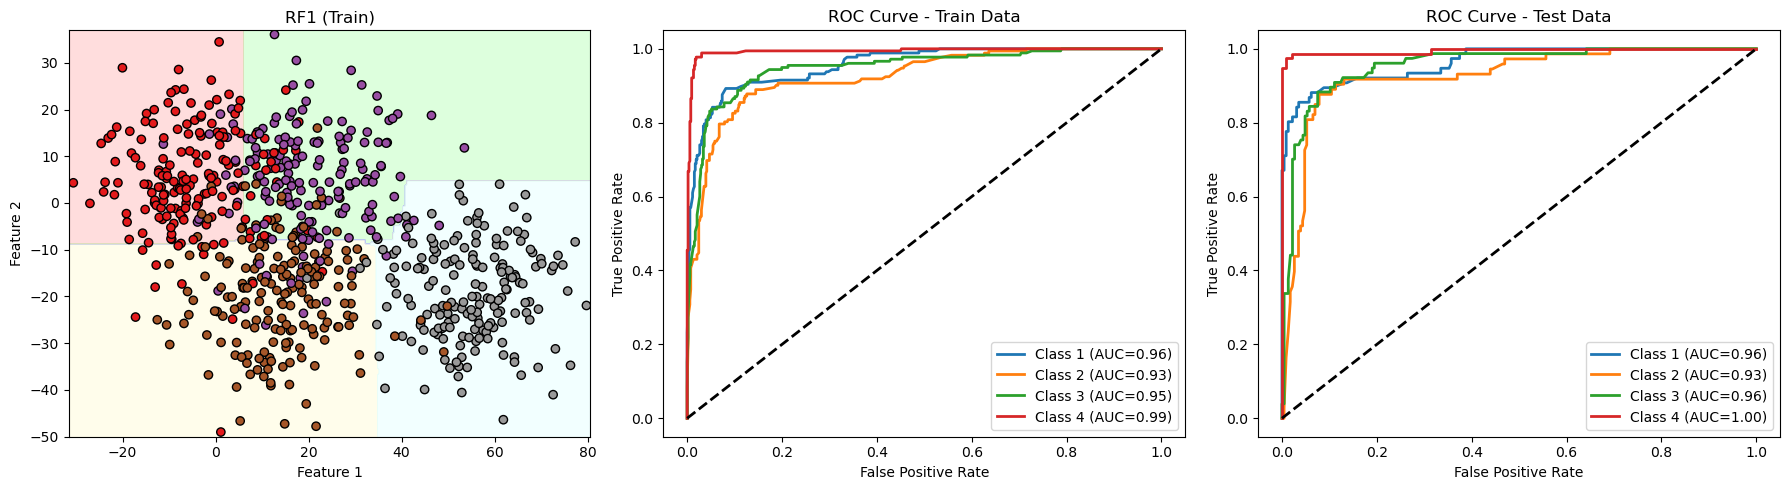

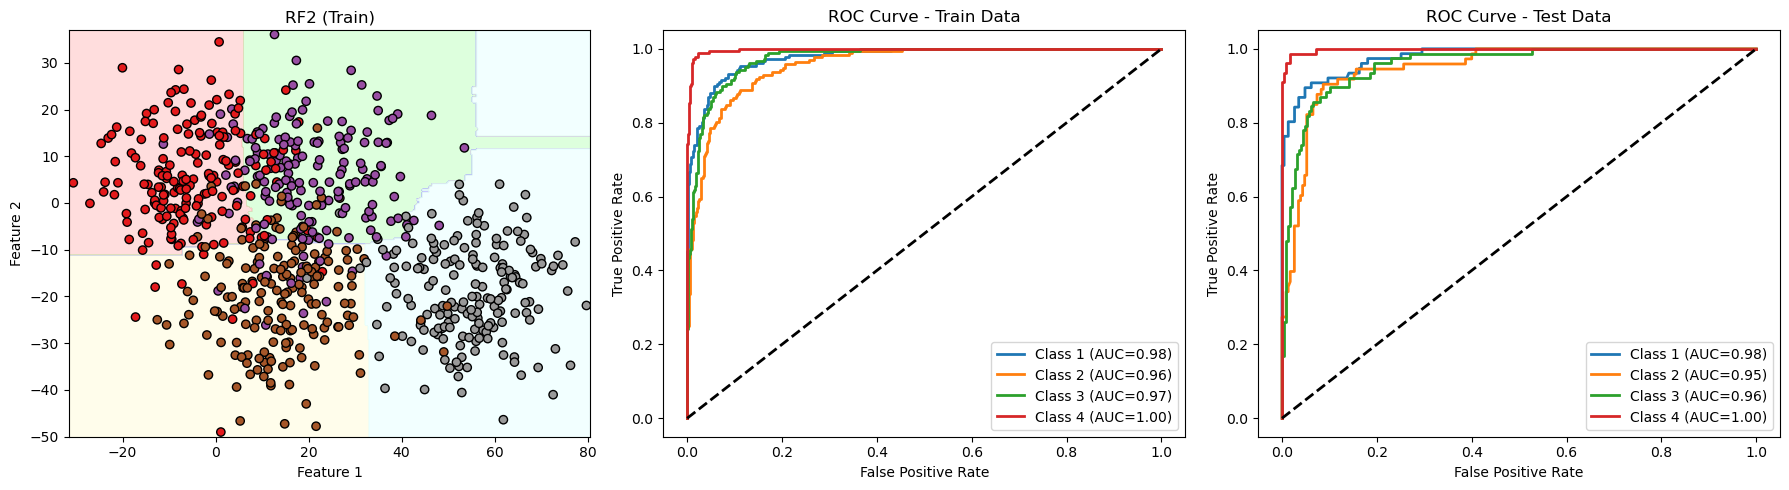

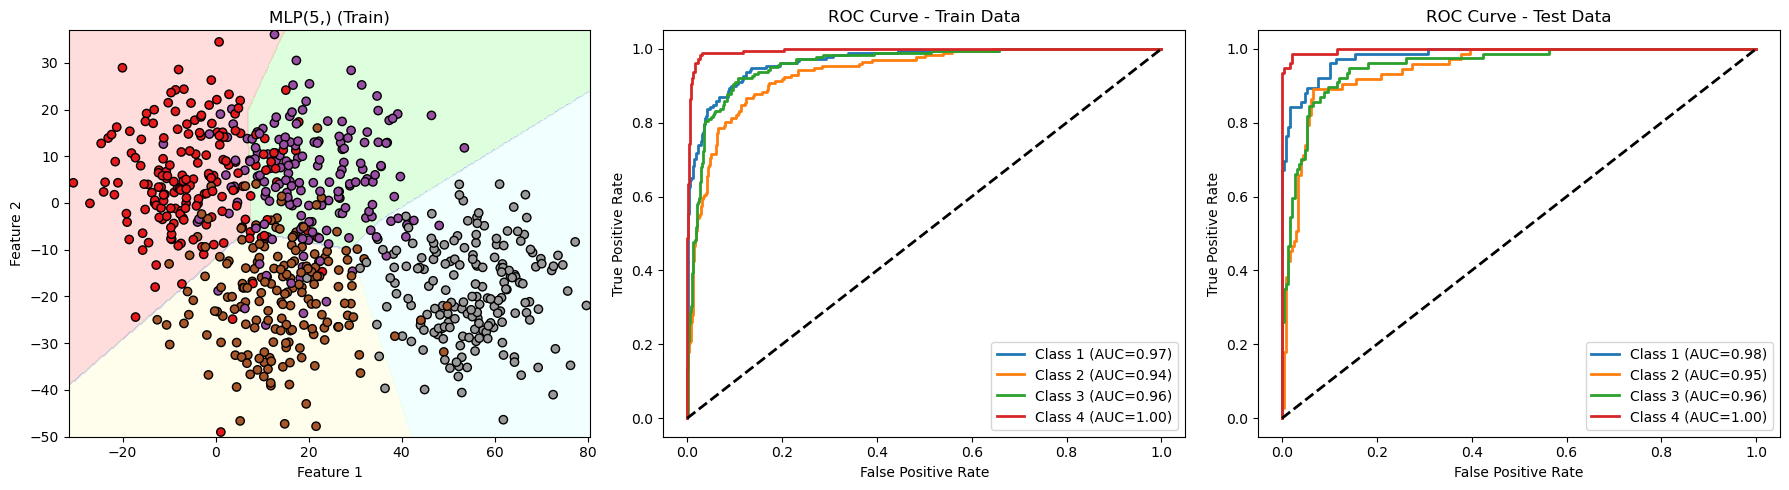

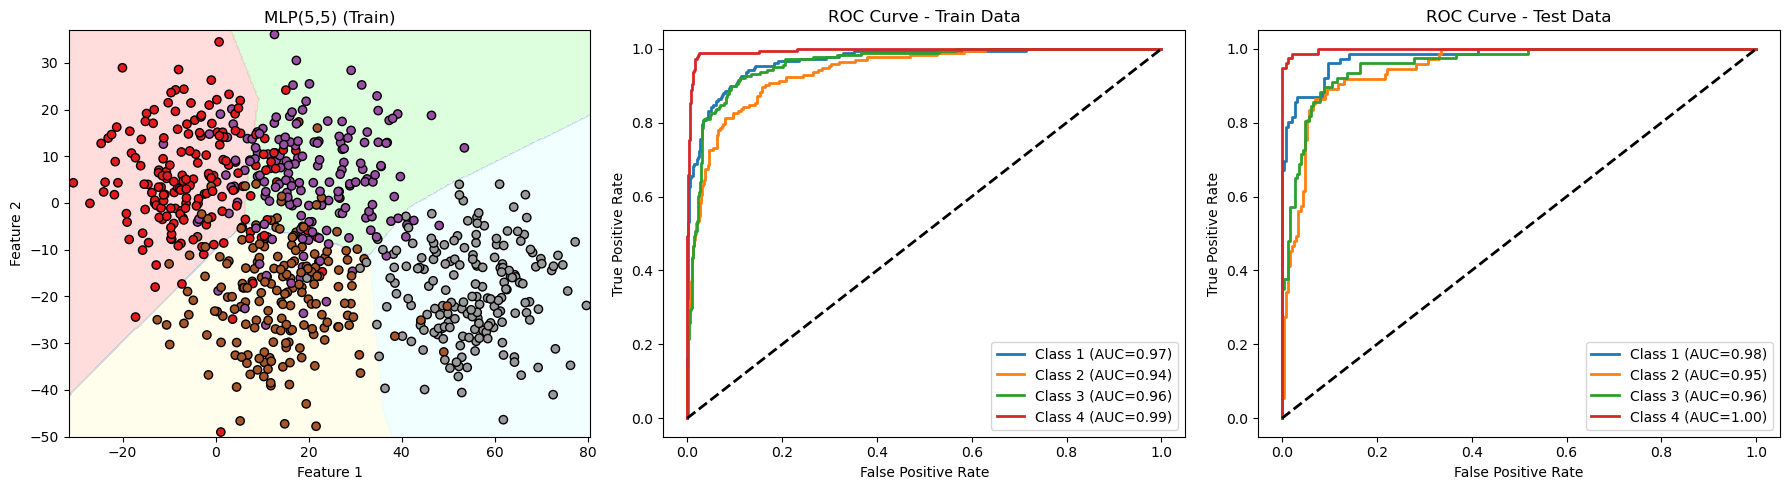

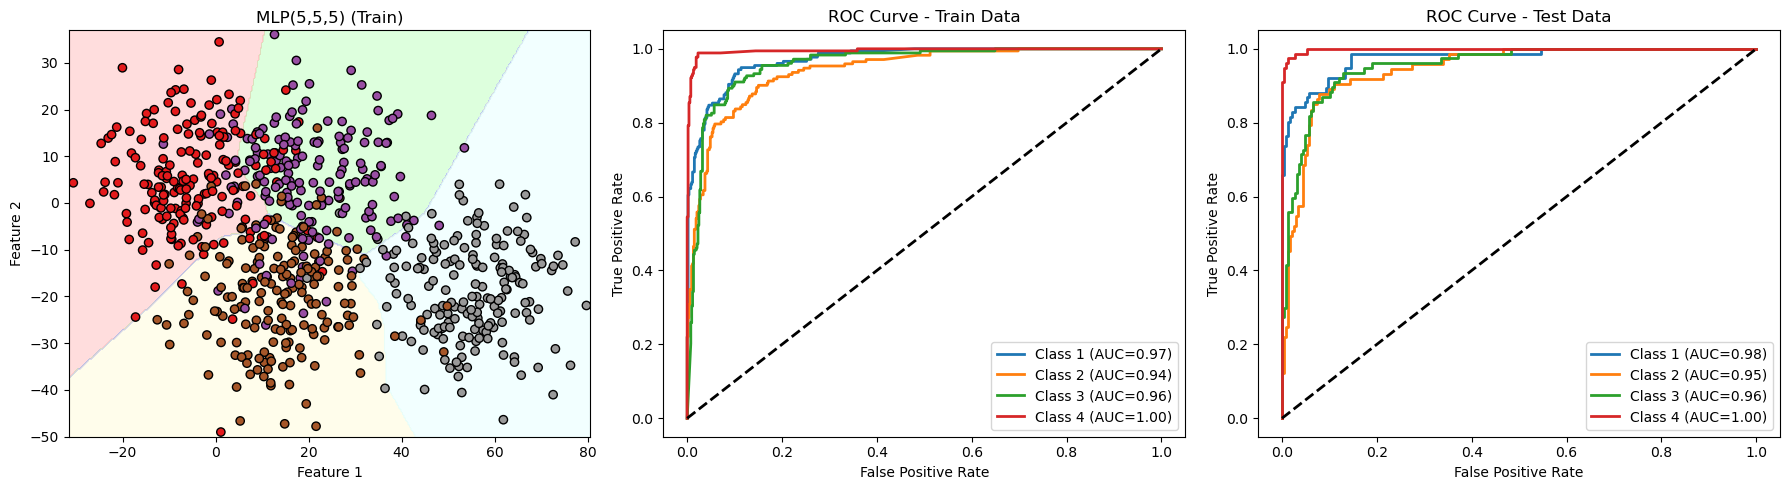

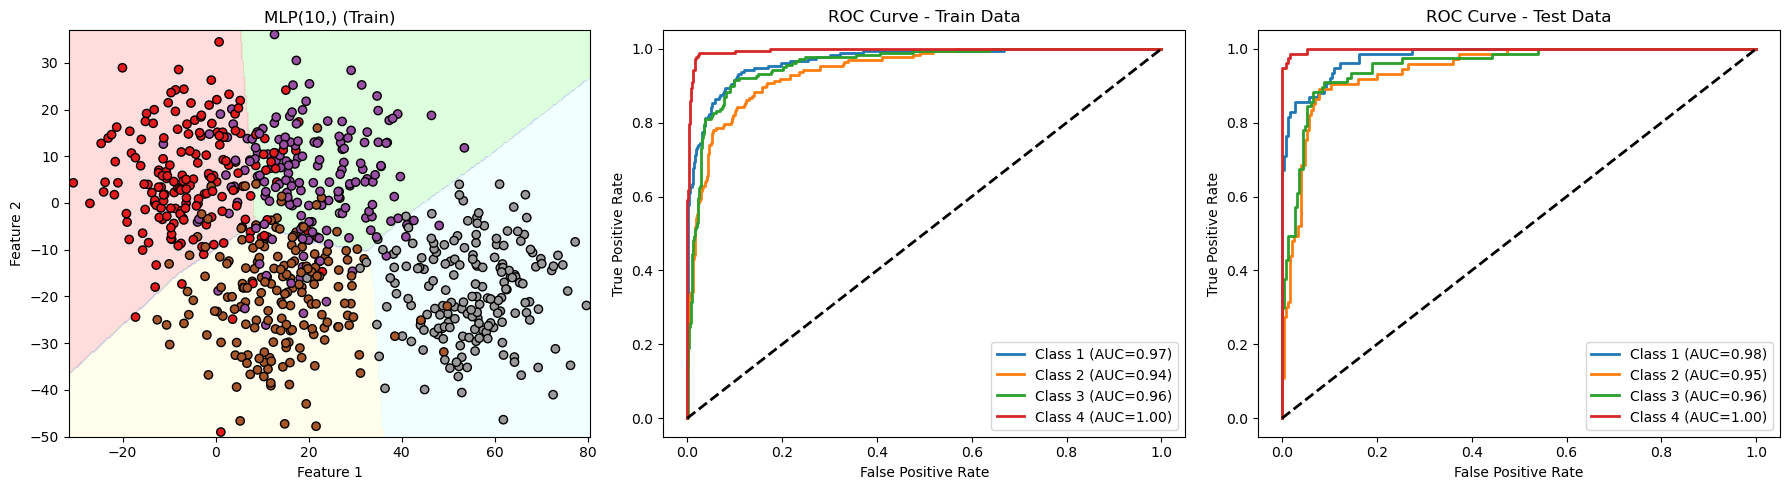

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y, ax, title):
    t1=time.time()
    h = 0.3
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    try:
           Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    except Exception as e:
        print(f"Could not plot decision boundary: {e}")
        ax.set_title(title + "\n(Decision boundary error)")
        ax.axis('off')
        return
    
    Z = Z.reshape(xx.shape)
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFACD', '#E0FFFF'])
    ax.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.4)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.Set1)
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    t2=time.time()
    #print("Time taken to plot decision boundary in milliseconds for model :", (t2-t1)*1000,model)

def plot_multiclass_roc(model, X, y, ax, title):
    t1=time.time()
    classes = np.unique(y)
    if len(classes) == 2:
        # Binary ROC
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_estimator(model, X, y, ax=ax)
        ax.set_title(title)
        return
    # Multiclass ROC (one-vs-rest)
    y_bin = label_binarize(y, classes=classes)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    else:
        ax.set_title(title + "\n(No ROC available)")
        ax.axis('off')
        return
    for i, c in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, lw=2, label=f'Class {c} (AUC={roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc='lower right')
    t2=time.time()
    #print("Time taken to plot ROC curve in milliseconds for model :", (t2-t1)*1000,model)


for name, est in models.items():
    t1=time.time()
    mdl = clone(est)
    mdl.fit(X_train, y_train)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # 1. Scatter plot (decision boundary)
    if X_train.shape[1] == 2:
        plot_decision_boundary(mdl, X_train, y_train, axes[0], f"{name} (Train)")
    else:
        axes[0].set_title(f"{name}\n(Decision boundary only for 2D)")
        axes[0].axis('off')
    # 2. ROC curve train
    plot_multiclass_roc(mdl, X_train, y_train, axes[1], "ROC Curve - Train Data")
    # 3. ROC curve test
    plot_multiclass_roc(mdl, X_test, y_test, axes[2], "ROC Curve - Test Data")
    plt.tight_layout()
    plt.show()
    t2=time.time()
   # print("time taken for model in milliseconds:", name,(t2-t1)*1000)